Dataset Processing

We intend to use three different models to predict the age of a given person.

Let's start with importing what we need for this classification task.

In [192]:
# All imports in here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

Let's have a look at our text data.

In [193]:
# Load dataset as DataFrames
df = pd.read_csv('data/UTKFaceAugmented.csv', index_col=0)
df

,filename,age,gender,race,age_range,num_haircuts_life,has_tiktok,remembers_disco,uses_skincare,max_annual_earnings
0,100_0_0_20170112213500903.jpg.chip.jpg,100,male,white,100-119,360,no,no,no,32890.160162
1,100_0_0_20170112215240346.jpg.chip.jpg,100,male,white,100-119,627,no,no,no,29870.803247
2,100_1_0_20170110183726390.jpg.chip.jpg,100,female,white,100-119,687,no,yes,no,62930.622654
3,100_1_0_20170112213001988.jpg.chip.jpg,100,female,white,100-119,710,no,no,no,31105.957009
4,100_1_0_20170112213303693.jpg.chip.jpg,100,female,white,100-119,614,no,no,no,63977.673549
...,...,...,...,...,...,...,...,...,...,...
23703,9_1_3_20161220222856346.jpg.chip.jpg,9,female,indian,0-19,52,no,no,no,0.000000
23704,9_1_3_20170104222949455.jpg.chip.jpg,9,female,indian,0-19,55,no,no,no,0.000000
23705,9_1_4_20170103200637399.jpg.chip.jpg,9,female,other,0-19,51,yes,no,no,0.000000
23706,9_1_4_20170103200814791.jpg.chip.jpg,9,female,other,0-19,60,no,no,no,0.000000


In [194]:
# See what type of data we have in each column
print(df.dtypes)

filename                object
age                      int64
gender                  object
race                    object
age_range               object
num_haircuts_life        int64
has_tiktok              object
remembers_disco         object
uses_skincare           object
max_annual_earnings    float64
dtype: object


Time for feature selection. Looking at the .csv file, gender, race, TikTok account possession, and skincare usage don't have much correlation with age. Number of haircuts in life and whether the person remembers disco seem better. Maximum annual earnings seems less useful, at least it does a good job of filtering out 0-19-year-olds, but after that it doesn't seem to have a very strong correlation with age. I will include it nevertheless.

In [195]:
# drop irrelevant feature columns
df = df.drop(['gender', 'race', 'has_tiktok', 'uses_skincare'], axis = 1)

Analyze numeric data.

Text(0.5, 0, 'max_annual_earnings')

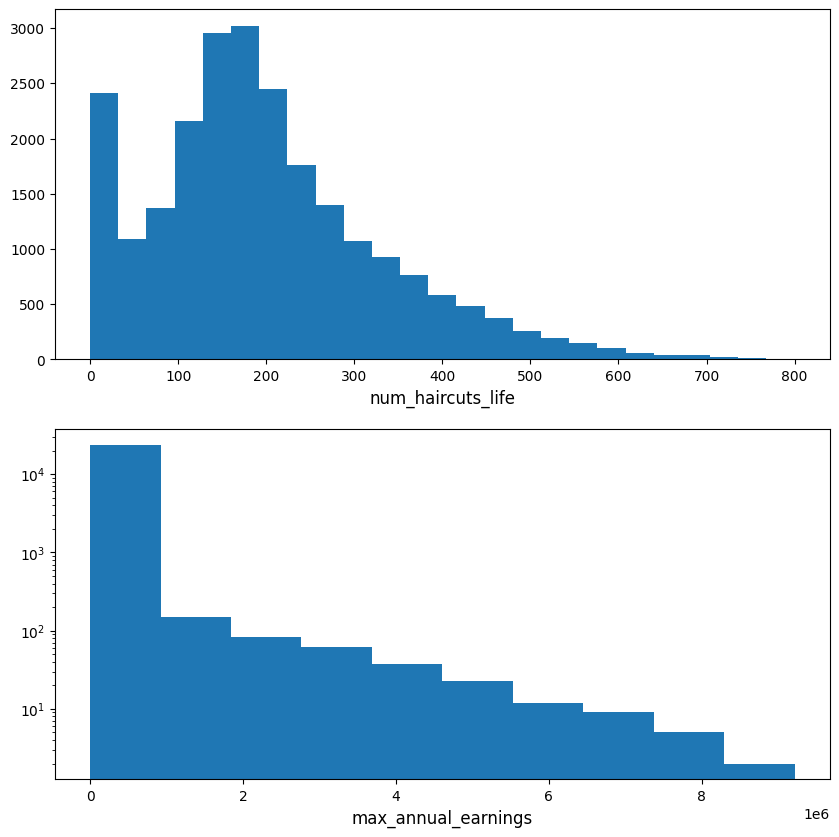

In [196]:
# Visualize our data
numeric_columns = ["num_haircuts_life", "max_annual_earnings"]
fig, axs = plt.subplots(2,1, figsize =(10,10))
axs[0].hist(df[numeric_columns[0]], bins = 25)
axs[0].set_xlabel(numeric_columns[0], fontsize = 12)
# use logarithmic axis to visualize wage data
axs[1].hist(df[numeric_columns[1]], log = True)
axs[1].set_xlabel(numeric_columns[1], fontsize = 12)

Text(0.5, 0, 'max_annual_earnings_st')

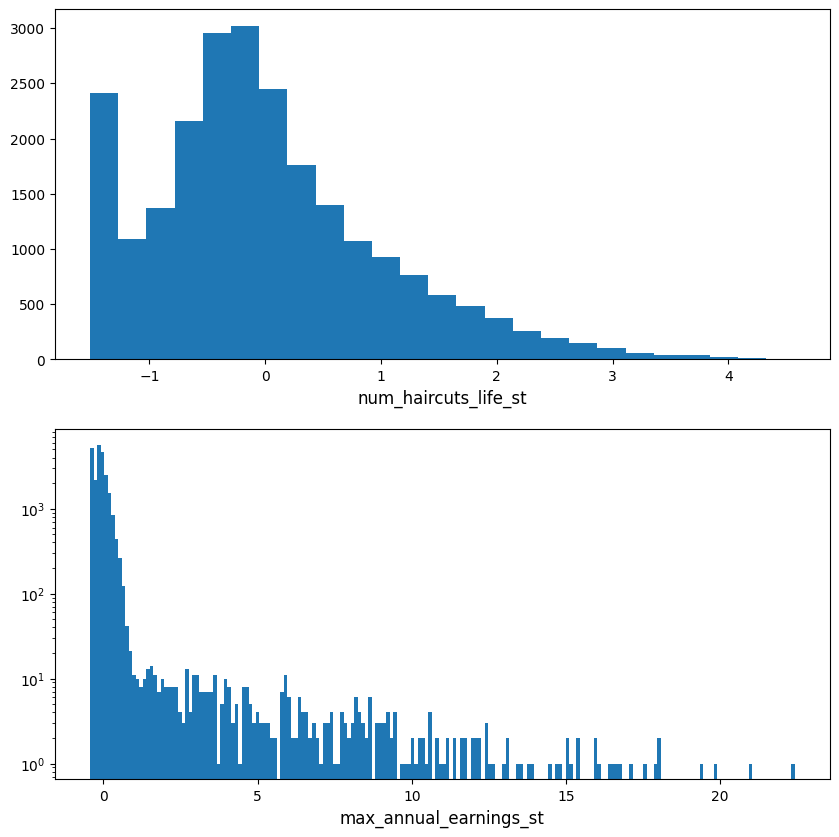

In [197]:
# Standardize our numeric data
def standardize_numeric(series: pd.Series, use_log: bool = False) -> pd.Series:
    if use_log:
        series = np.log(series)
    series = (series - np.mean(series)) / np.std(series)
    return series
    
df['num_haircuts_life_st'] = standardize_numeric(df['num_haircuts_life'], False)
df['max_annual_earnings_st'] = standardize_numeric(df['max_annual_earnings'], False)

# visualize the standardized numeric data
numeric_columns = ["num_haircuts_life_st", "max_annual_earnings_st"]
fig, axs = plt.subplots(2,1, figsize =(10,10))
axs[0].hist(df[numeric_columns[0]], bins = 25)
axs[0].set_xlabel(numeric_columns[0], fontsize = 12)
# use logarithmic axis to visualize wage data
axs[1].hist(df[numeric_columns[1]], bins = 200, log = True)
axs[1].set_xlabel(numeric_columns[1], fontsize = 12)

In [198]:
# Prepare categorical data
keep_categoric_columns = ['remembers_disco']
for col in keep_categoric_columns:
    df = df.join(pd.get_dummies(df[col], dtype='int'), how = 'outer')
df.head(10)

,filename,age,age_range,num_haircuts_life,remembers_disco,max_annual_earnings,num_haircuts_life_st,max_annual_earnings_st,no,yes
0,100_0_0_20170112213500903.jpg.chip.jpg,100,100-119,360,no,32890.160162,1.225473,-0.353687,1,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,100-119,627,no,29870.803247,3.256254,-0.361172,1,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,100-119,687,yes,62930.622654,3.712609,-0.279210,0,1
3,100_1_0_20170112213001988.jpg.chip.jpg,100,100-119,710,no,31105.957009,3.887545,-0.358110,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,100-119,614,no,63977.673549,3.157377,-0.276614,1,0
5,100_1_0_20170112215032192.jpg.chip.jpg,100,100-119,427,no,37422.839290,1.735070,-0.342449,1,0
6,100_1_0_20170117195420803.jpg.chip.jpg,100,100-119,568,yes,53988.009196,2.807504,-0.301381,0,1
7,100_1_0_20170119212053665.jpg.chip.jpg,100,100-119,766,no,41449.094825,4.313477,-0.332467,1,0
8,100_1_2_20170105174847679.jpg.chip.jpg,100,100-119,527,no,42429.537615,2.495662,-0.330037,1,0
9,100_1_2_20170112213615815.jpg.chip.jpg,100,100-119,354,no,48179.281854,1.179837,-0.315782,1,0


In [199]:
# Coversion time
# list out all finalized input and output feature columns
features = ['num_haircuts_life_st', 'max_annual_earnings_st', 'yes', 'no']
targets = ['age']

# create new dataframes of inputs and outputs
train_df = df[features + targets]

# split our dataset
# split train and val
x_train, x_val, y_train, y_val = train_test_split(train_df[features], train_df[targets], train_size=0.6)

# split again to get a test set
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, train_size=0.5)

print("x train: ",x_train.shape, "y train:", y_train.shape)
print("x val: ",x_val.shape, "y train:", y_val.shape)
print("x test: ",x_test.shape, "y test:", y_test.shape)

x train:  (14224, 4) y train: (14224, 1)
x val:  (4742, 4) y train: (4742, 1)
x test:  (4742, 4) y test: (4742, 1)


Convert data into tensors and save it to the disk so we can use it in our models

In [200]:

# dataframes -> numpy arrays -> tensors
print(x_train)
x_train, x_val, x_test = torch.Tensor(x_train.to_numpy()), torch.Tensor(x_val.to_numpy()), torch.Tensor(x_test.to_numpy())
y_train, y_val, y_test = torch.Tensor(y_train.to_numpy()), torch.Tensor(y_val.to_numpy()), torch.Tensor(y_test.to_numpy())

# store it in a dict that we can save out as a single file
data_dict = {'x_train':x_train, 'x_val':x_val, 'x_test':x_test, 'y_train':y_train, 'y_val':y_val, 'y_test':y_test}

# save it to local data directory
torch.save(data_dict, 'data/ages_processed.pt', )

       num_haircuts_life_st  max_annual_earnings_st  yes  no
13904             -0.288105               -0.091820    0   1
22641              3.537673               -0.159709    0   1
20497              2.488056               -0.335045    1   0
22104              1.849158               -0.174960    1   0
16514             -0.447830                0.130445    0   1
...                     ...                     ...  ...  ..
5327               0.388822               -0.080937    0   1
9570              -0.166410                1.812753    0   1
12993             -0.493465               -0.174822    0   1
14367              0.731088                0.123827    0   1
23581             -1.246451               -0.435229    0   1

[14224 rows x 4 columns]


Now it's time for the image data:

In [204]:
# start with image processing imports
import os
from tqdm.notebook import tqdm

image_paths = []
age_labels = []

for filename in tqdm(os.listdir('data/images')):
    image_path = os.path.join('data/images', filename) # the first numbers in the image filenames are the age of the subject
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

# convert paths to dataframe
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

  0%|          | 0/23708 [00:00<?, ?it/s]

,image,age
0,data/images\100_0_0_20170112213500903.jpg.chip...,100
1,data/images\100_0_0_20170112215240346.jpg.chip...,100
2,data/images\100_1_0_20170110183726390.jpg.chip...,100
3,data/images\100_1_0_20170112213001988.jpg.chip...,100
4,data/images\100_1_0_20170112213303693.jpg.chip...,100


In [219]:
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch

df['image'] = df['image'].astype(str)

# Feature extraction
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = Image.open(image_path).convert("L")  # Open image and convert to grayscale
        img = img.resize((128, 128))  # Resize image to 128x128 pixels
        img_array = np.array(img)
        features.append(img_array)

    features = np.array(features)
    features = features.reshape(len(features), 1, 128, 128)  # Reshape to (batch_size, channels, height, width)
    return features

# Feature extraction
X = extract_features(df['image'])

# Normalize features
X = X / 255.0

# Create a NumPy array for the target variable
y_age = np.array(df['age'])

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_age, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert NumPy arrays to PyTorch tensors
x_train, x_val, x_test = torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test)
y_train, y_val, y_test = torch.Tensor(y_train), torch.Tensor(y_val), torch.Tensor(y_test)

# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

# Save datasets as a single file
torch.save({'train': train_dataset, 'val': val_dataset, 'test': test_dataset}, 'data/dataset.pt')

100%|██████████| 23708/23708 [00:48<00:00, 492.47it/s]
